# Preprocessing

In [1]:
import mne
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP
def creat_mne_raw_object(fname,read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

In [2]:
# testing
raw = creat_mne_raw_object("grasp-and-lift-eeg-detection/train/subj1_series1_data.csv")

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>


<ipython-input-1-b34a1d135c1e>:43: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)


34 events found
Event IDs: [1]


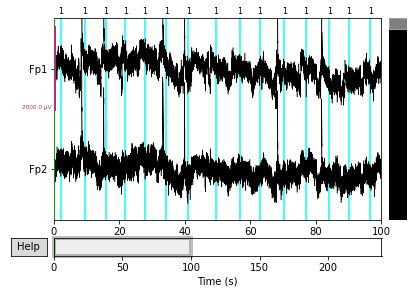

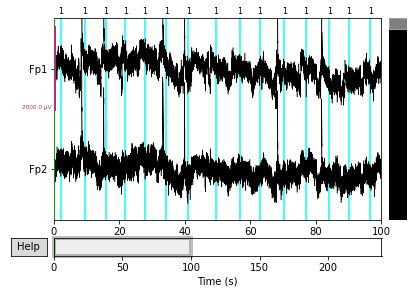

In [44]:
# plotting 
# scaling is necessary to show the graphs properly
# vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(n_channels=2,scalings=scalings,duration=100.0, events= events)

In [4]:
## transform to MNE from csv (no events,backup function)
# ch_names = list(df.columns)  # channel names    
# sfreq = 500 # sampling frequency, in hertz  
# samples = df[ch_names[1:]].to_numpy() # Samples for each channel  
# info = mne.create_info(ch_names[1:], sfreq)
# raw = mne.io.RawArray(samples.T, info)  
# raw.plot(n_channels = 1)

# play around with iSITH

In [5]:
import torch
import torch.nn
import torch.nn.functional as F
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
print(ttype)
# deep_iSITH is being used here, not deep_sith
from sith import iSITH
import matplotlib.pyplot as plt
%matplotlib inline

<class 'torch.DoubleTensor'>


In [37]:
signal = raw.get_data()
signal = signal[0,0:100]
ntau = 5
test_isith = iSITH(tau_min=1.0,dt=1, tau_max=200, ntau=ntau, ttype=ttype, g=0.2).cuda()
test_input = ttype(signal.reshape(1,1,1,-1, 1))
test_input.shape

torch.Size([1, 1, 1, 100, 1])

In [38]:
repeats = 1
test_input1 = test_input.repeat(1,1,1,1,repeats).view(1,1,1,-1)
print(test_input1.shape)

torch.Size([1, 1, 1, 100])


In [39]:
repeats = 2
test_input2 = test_input.repeat(1,1,1,1,repeats).view(1,1,1,-1)
print(test_input2.shape)

torch.Size([1, 1, 1, 200])


In [40]:
out1 = test_isith(test_input1[:, :, :, :])
print(out1.shape)

torch.Size([1, 5, 1, 100])


In [41]:
out2 = test_isith(test_input2[:, :, :, :])
print(out2.shape)

torch.Size([1, 5, 1, 200])


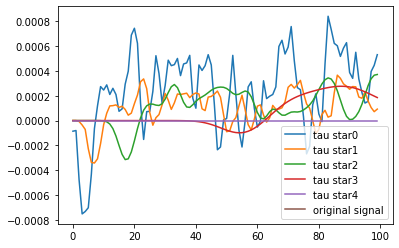

In [42]:
for i in range(ntau):
    
    plt.plot(out1[0, i, 0, :].detach().cpu(),label=f'tau star{i}' );
    #plt.plot(out2[0, :, 0, -1].detach().cpu());
plt.plot(signal[0],label="original signal")
plt.legend()
plt.show()

In [ ]:
plt.plot(out1[0, 0, 0, :].detach().cpu(),label=f'tau star{i}' );

In [114]:
inp = test_input2
out = torch.conv2d(inp, test_isith.filters[:, :, :, -inp.shape[-1]-2:], 
                   padding=[0, test_isith.filters[:, :, :, -inp.shape[-1]-2:].shape[-1]])
out2 = out[:, :, :, 2:inp.shape[-1]+2]*test_isith.dt*test_isith.k/(test_isith.k+1)
#plt.plot(test_input2[0,0,0,:])
i=0
print(out2.shape)

torch.Size([1, 100, 1, 200])


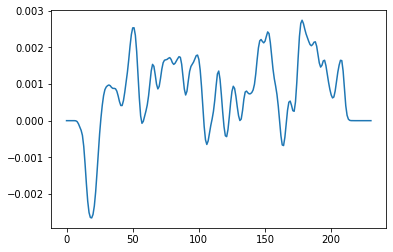

In [120]:
plt.plot(out[0,99,0,:])

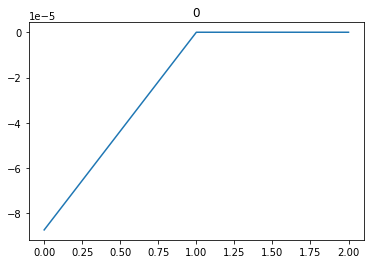

In [73]:
plt.plot(out[0, :, 0, 2+i]);
plt.title("{}".format(i))
i+=1